In [1]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [2]:
# Import dataset with panda
df = pd.read_csv('output.csv')
df.head()

,round,embb_req,embb_giv,embb_user,embb_true,urllc_req,urllc_giv,urllc_user,urllc_true,miot_req,...,miot_true,mmtc_req,mmtc_giv,mmtc_user,mmtc_true,voice_req,voice_giv,voice_user,voice_true,band_rem
0,0,0,0,63,0,0,0,29,0,0,...,0,0,0,25,0,0,0,48,0,20000000000
1,1,22770506827,5714135288,106,18635735325,108516686,108516686,55,108516686,138770107,...,138770107,122354150,122354150,45,122354150,278457373,48000000,77,186773995,13868223769
2,2,36411441008,6442330261,184,18493257400,119594292,119594292,113,119594292,145688811,...,145688811,102667659,102667659,83,102667659,404059909,77000000,135,193477719,13112718977
3,3,66291466083,10793401450,197,17582512997,347251000,347251000,114,347251000,289932361,...,289932361,300506617,300506617,86,300506617,671339575,134000000,140,364987842,8134908572
4,4,64121897133,11078649651,205,17951980096,236611815,228160714,125,236611815,230846119,...,230846119,168838186,168838186,93,168838186,564776562,139000000,145,380984920,8154505330


In [3]:
# Parametes 
TRAIN_SPLIT = 22000
tf.random.set_seed(13)

#features_considered = ['embb_req', 'embb_giv', 'embb_user', 'embb_true', 'urllc_req', 'urllc_giv', 'urllc_user', 'urllc_true','miot_req', 'miot_giv', 'miot_user', 'miot_true','mmtc_req', 'mmtc_giv', 'mmtc_user', 'mmtc_true','voice_req', 'voice_giv', 'voice_user', 'voice_true', 'band_rem']
features_considered = ['embb_req', 'embb_giv', 'embb_user', 'embb_true']
features = df[features_considered]
features.index = df['round']
features.head()

,embb_req,embb_giv,embb_user,embb_true
round,,,,
0,0,0,63,0
1,22770506827,5714135288,106,18635735325
2,36411441008,6442330261,184,18493257400
3,66291466083,10793401450,197,17582512997
4,64121897133,11078649651,205,17951980096


In [4]:
# normalize dataset
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std

In [5]:
def multivariate_data(dataset, target, start_index, end_index, history_size, target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [6]:
# Create validation and training set
past_history = 10
future_target = 0
step = 1

x_train, y_train = multivariate_data(dataset, dataset[:, 3], 0, TRAIN_SPLIT, past_history,future_target, step, single_step=True)
x_val, y_val = multivariate_data(dataset, dataset[:, 3], TRAIN_SPLIT, None, past_history, future_target, step, single_step=True)


In [8]:
BATCH_SIZE = 1 # combines consecutive elements of this dataset into batches.
BUFFER_SIZE = 30000 # >= len dataset for perfetct shuffling

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_data = val_data.batch(BATCH_SIZE).repeat()


In [9]:
# Create RNN
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(80))
model.add(tf.keras.layers.Dense(1))

model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

In [12]:
# Train RNN

EVALUATION_INTERVAL = 200 # complete training data for better results
EPOCHS = 10

single_step_history = model.fit(train_data, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data,
                                            validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 5s 27ms/step - loss: 0.5172 - val_loss: 1.0794
Epoch 2/10
200/200 [==============================] - 2s 9ms/step - loss: 0.5827 - val_loss: 1.0287
Epoch 3/10
200/200 [==============================] - 2s 11ms/step - loss: 0.3486 - val_loss: 1.0745
Epoch 4/10
200/200 [==============================] - 2s 10ms/step - loss: 0.4209 - val_loss: 0.9989
Epoch 5/10
200/200 [==============================] - 2s 10ms/step - loss: 0.4027 - val_loss: 0.9933
Epoch 6/10
200/200 [==============================] - 3s 16ms/step - loss: 0.4225 - val_loss: 1.0032
Epoch 7/10
200/200 [==============================] - 4s 20ms/step - loss: 0.3564 - val_loss: 0.9912
Epoch 8/10
200/200 [==============================] - 3s 14ms/step - loss: 0.4086 - val_loss: 0.9819
Epoch 9/10
200/200 [==============================] - 3s 16ms/step - loss: 0.3595 - val_loss: 0.9910
Epoch 10/10
200/200 [============================

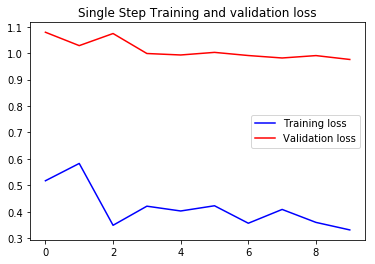

In [13]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

plot_train_history(single_step_history,
                   'Single Step Training and validation loss')